This script will
- Get data from stations
- Get processed altimeter data
- Plot data location
- Plot time series altimeter and station
- Calculate and Plot accuracies
- Separate low level from high levels

In [1]:
from ground_data import GroundObservations
from ts_preprocesing import *#get_date_time_cols
# from ts_preprocesing import convert_units
import importlib
import pandas as pd
import os
import datetime as dt
%load_ext autoreload
%autoreload 2

In [3]:
#Test Getting data from stations
#So far what works
# Getting locss stations
# Getting ARHN stations 
# Getting USGS stations from file. Still working on R script connection
go=GroundObservations()
lc_lakes=['KHB2','HMT2','PHN2','SAW2','RAW2','BTN2']
df_locss=go.read_ground_data('LOCSS', station_id=lc_lakes)
df_locss=get_date_time_cols(df_locss, 'date')
stations=df_locss['gauge_id'].unique()
height_fd='height'
df_final=convert_units(df_locss,height_fd, origin='FEET', to='METER', check_col=True, unit_fd='unit',
                   gauge_fd='gauge_id')
# print(df_final.columns)
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set(style='whitegrid')

# sns.displot(data=df_final, x='height', col='gauge_id')
# sns.displot(data=df_locss, x='height', col='gauge_id')

ar_lakes=['1805', '1819', '1824', '2830', '1830','2832', '2028','2102','2231','2234','2300','2316']
skip_rows=1
df_arhn=go.read_ground_data('ARHN', skip_rows=skip_rows, station_id=ar_lakes)
df_arhn=get_date_time_cols(df_arhn, 'date')
# print(df_arhn.columns)
# print(df_arhn.gauge_id.unique())
# print('/n..................../n',df_arhn.head(2))

us_lakes=['2464800','6903880','6604000']
df_usgs=go.read_ground_data('USGS',station_id=us_lakes)
df_usgs=get_date_time_cols(df_usgs, 'date')
# print(df_usgs.columns)

#falta Brazil



In [4]:
#Relevant columns
# df_ground_ts=pd.DataFrame()
common_cols=['gauge_id','source','decimal_y','height','date','year', 'month', 'day', 'hour']
df_usgs[common_cols]
df_ground_ts=pd.concat((df_usgs[common_cols].copy(),df_arhn[common_cols].copy(), df_locss[common_cols].copy()), axis=0)
# pd.datetime(+pd.to_datetime(df_final['time'], format='%H:%M:%S'), format='%Y-%m-%d %H:%M:%S')

In [12]:
def open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti=-9999):
    #Read altis
    (altiyear, altimonth, altiday, altihour, altiminute, altiwelev)=load_altis(g_path+altis_name+'.csv', 
                                                                               altis_date_fd, altis_height_fd, nodataalti=-9999)
    # Compute decimal year from year/month/day from altimetry time series
    altidy = np.array(list(map(yearmonthdayhourminutesec2decimalyear,
                           altiyear, altimonth, altiday, altihour,
                           altiminute, np.zeros(altiday.shape))))
    
    dic_altis={'decimal_y':altidy,'height':altiwelev,'year':altiyear, 'month':altimonth, 'day':altiday, 'hour':altihour}
    
    df_altis=pd.DataFrame(dic_altis)
    df_altis['name_altis']=altis_name
    df_gts_st=df_gts.loc[df_gts[st_fd]==st_id].copy()
    return (df_altis, df_gts_st)

(18, 8)
(13, 8)
Index(['lon', 'lat', 'altivs_nam', 'source', 'station_id', 'st_id_2',
       'geometry', 'tz'],
      dtype='object')


<ipython-input-14-c19dc3cb2eb6>:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i, figsize=(20, 6))


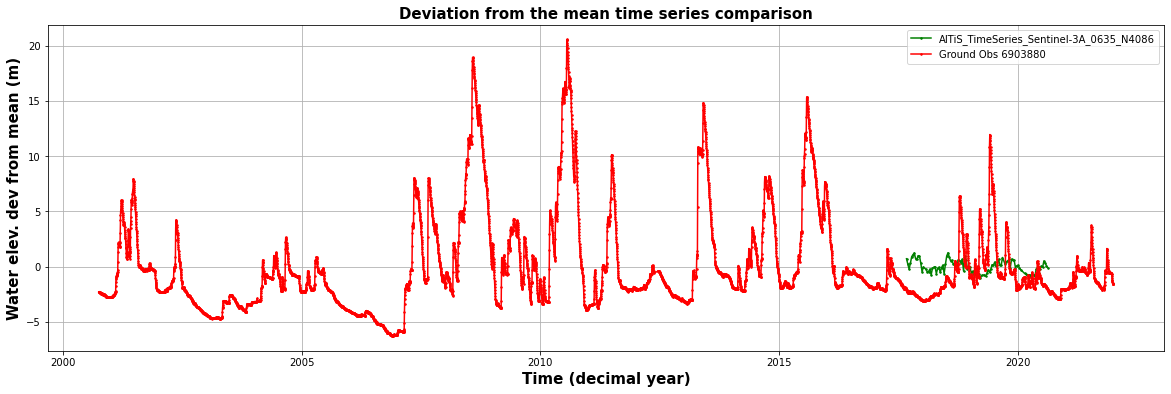

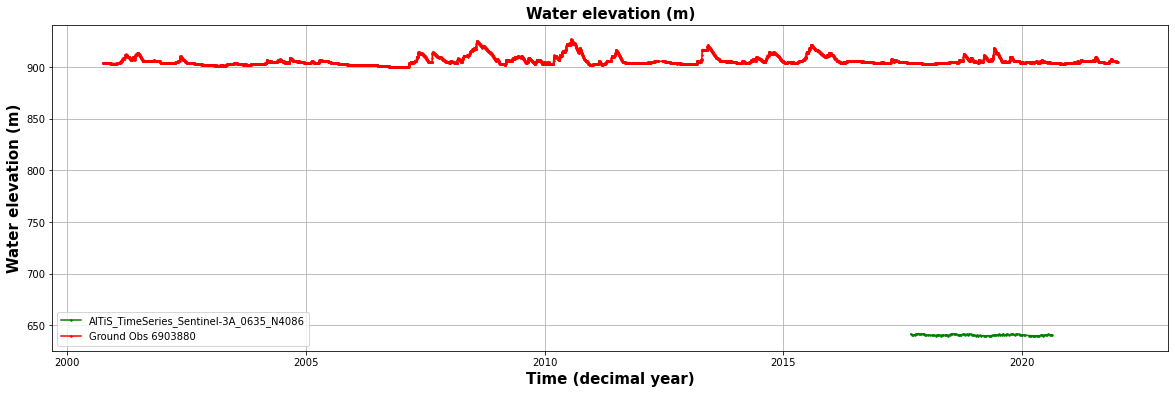

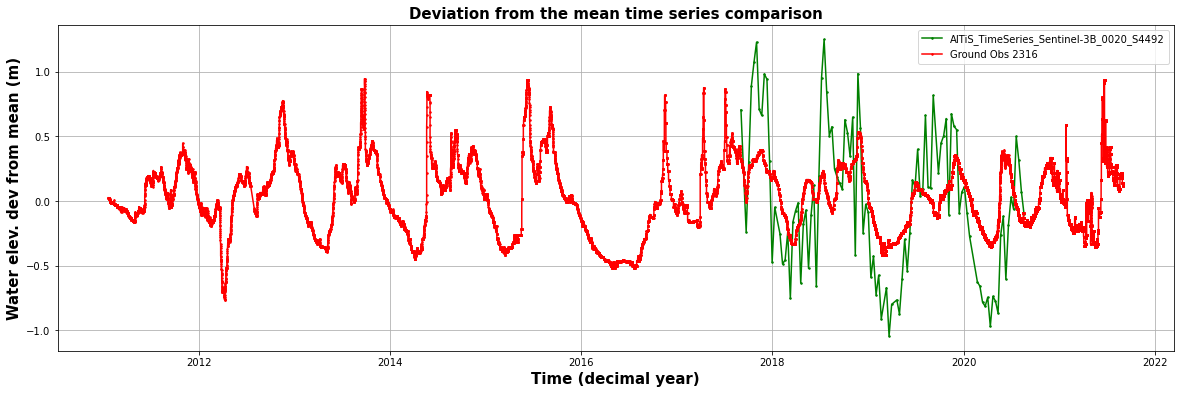

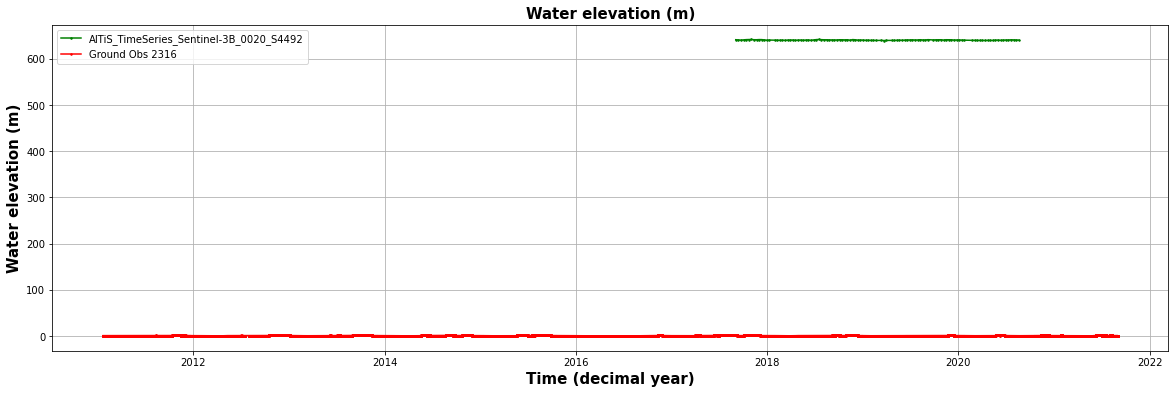

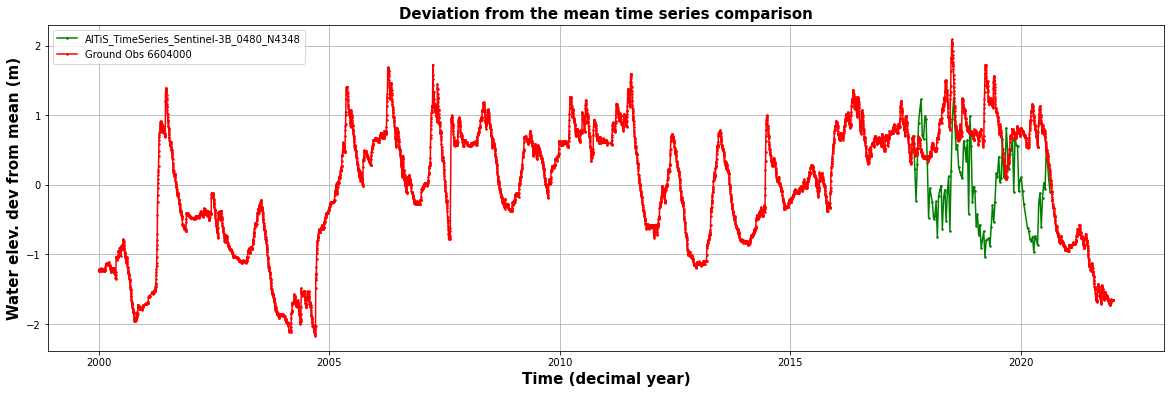

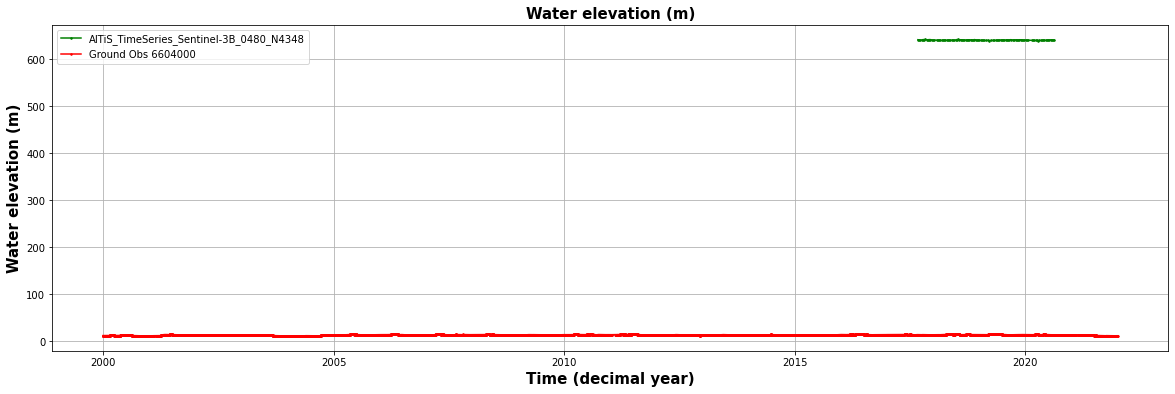

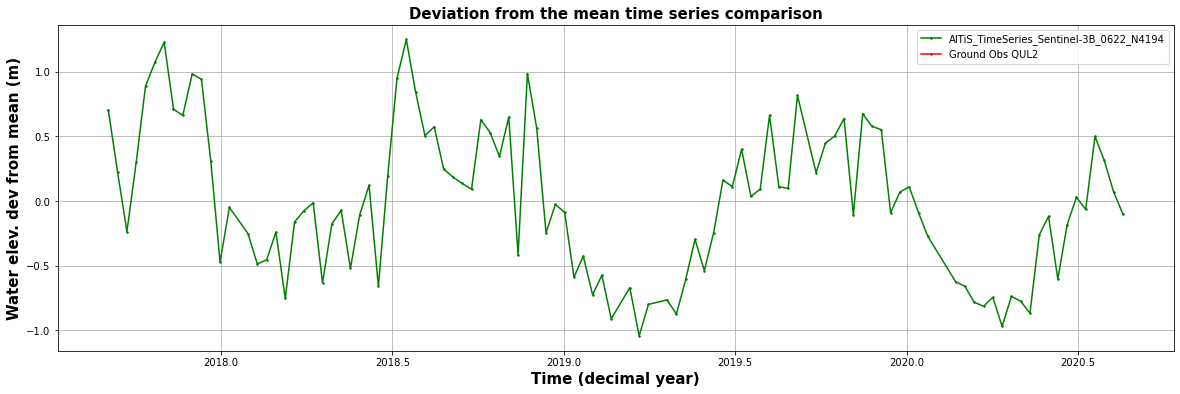

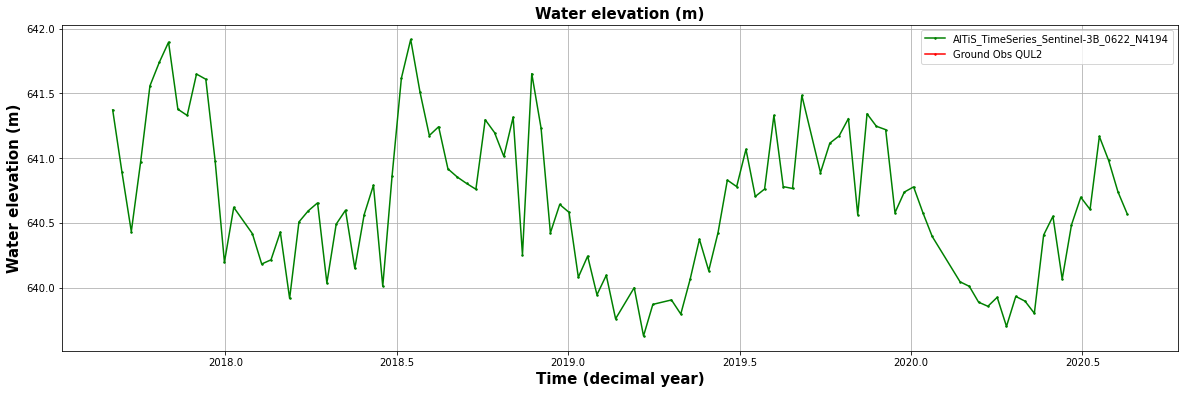

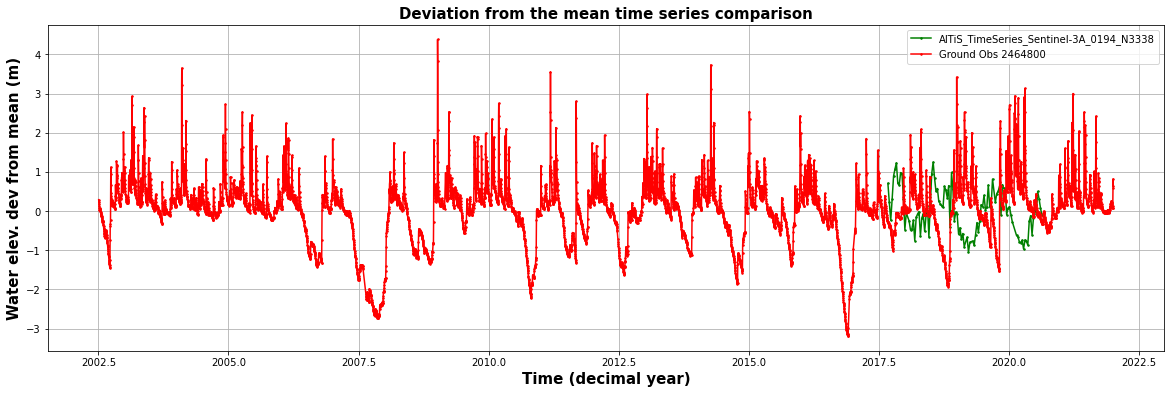

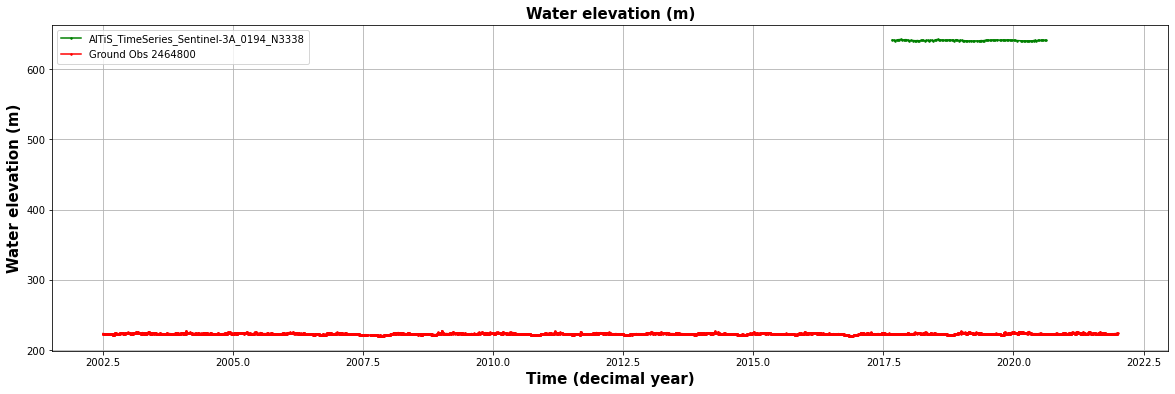

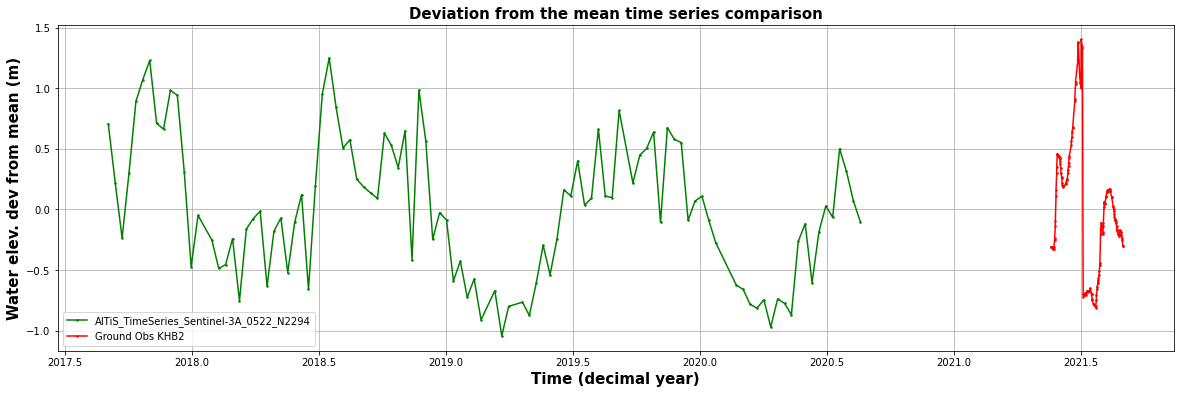

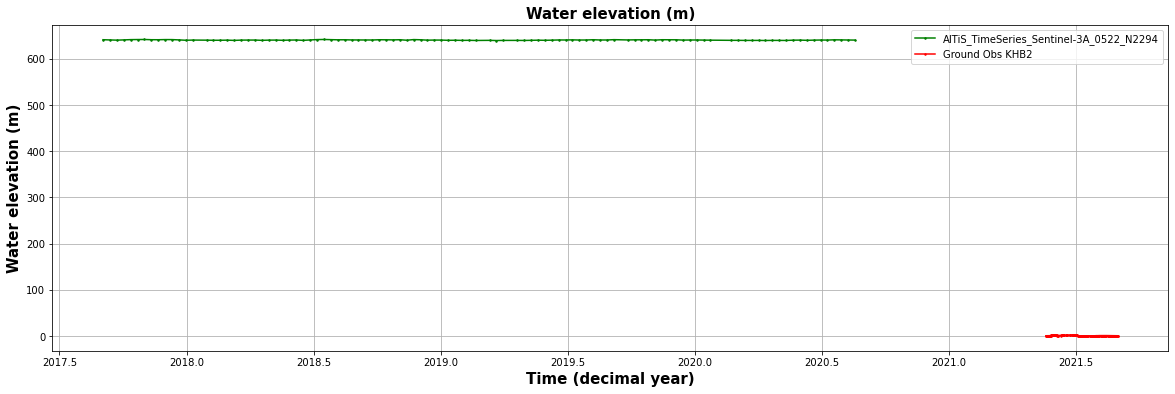

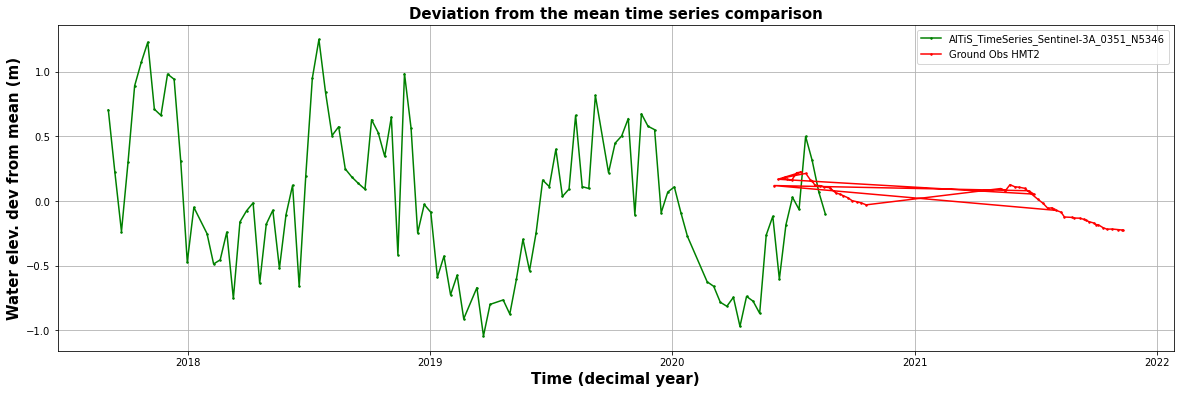

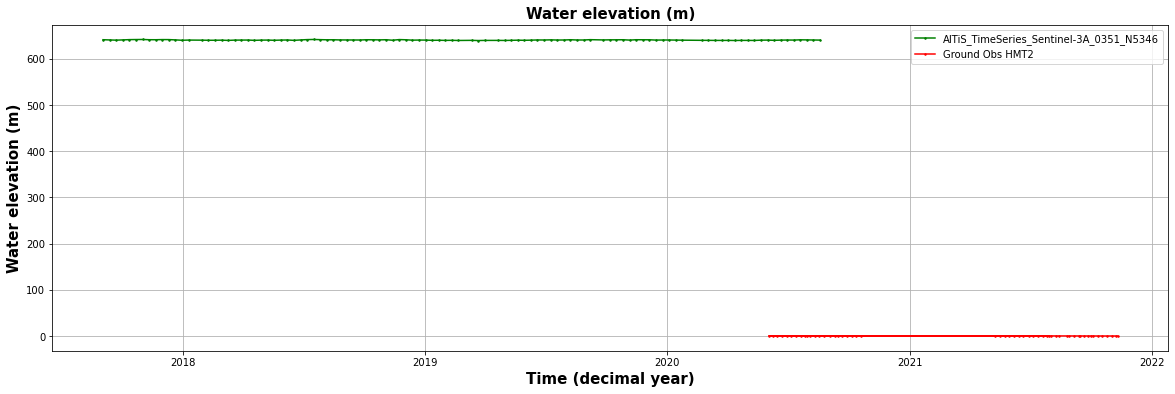

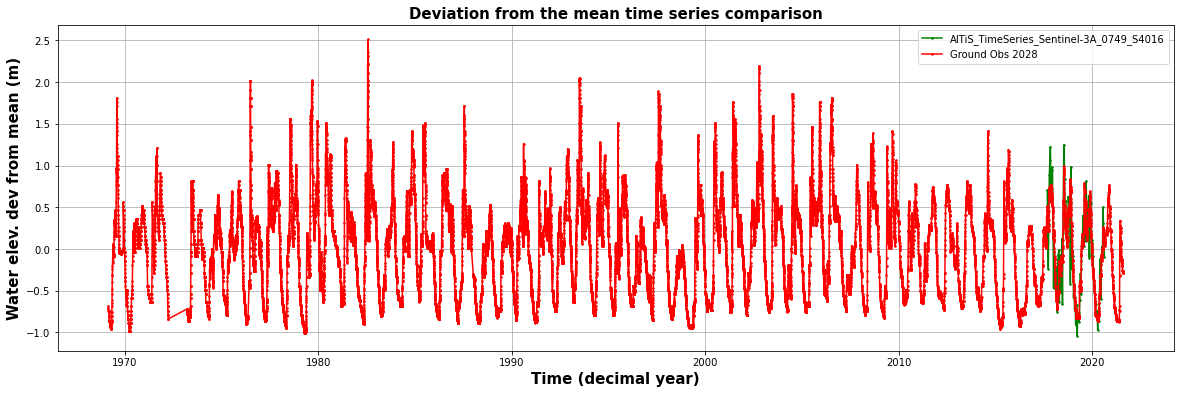

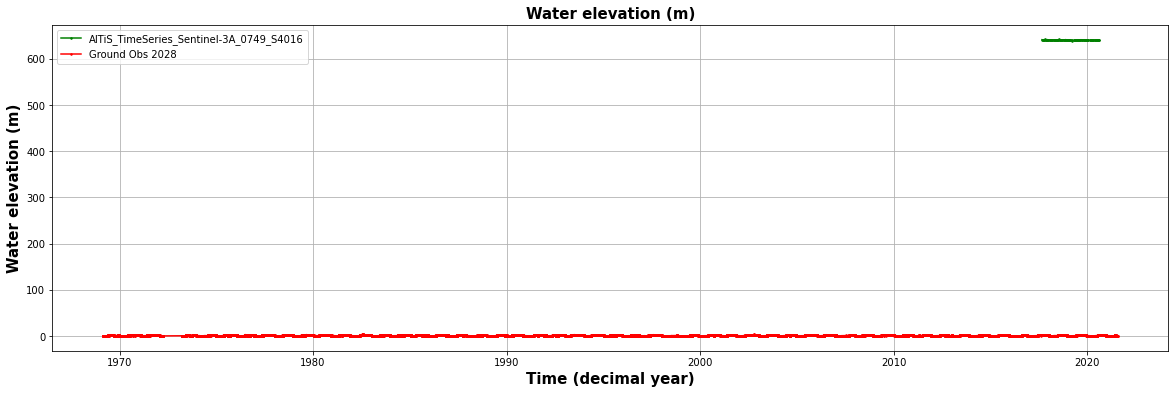

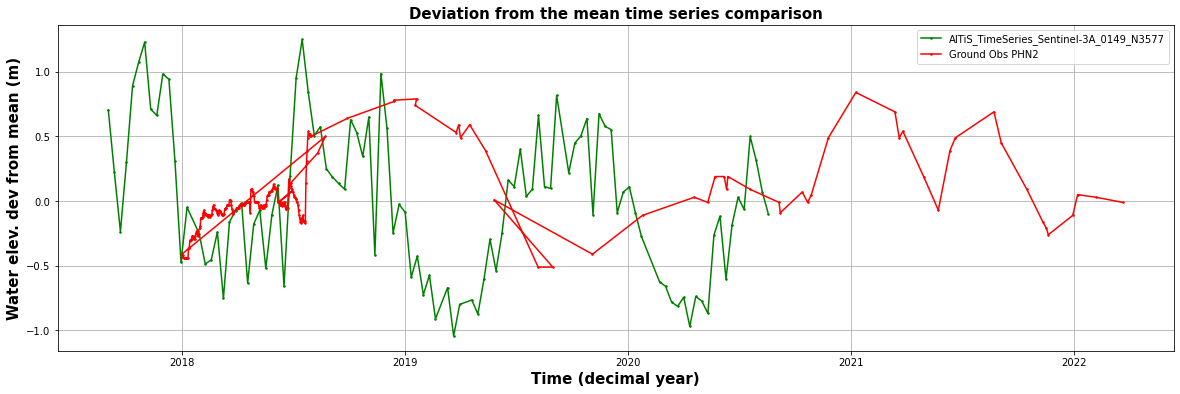

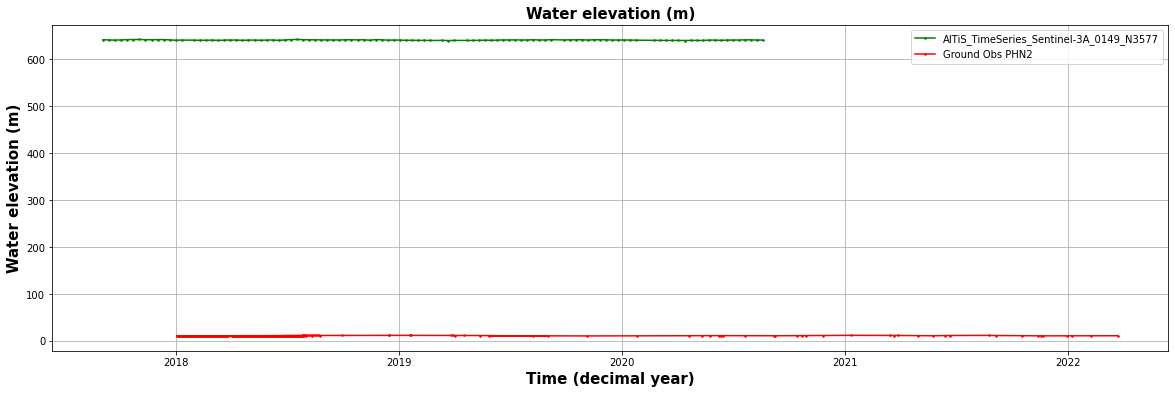

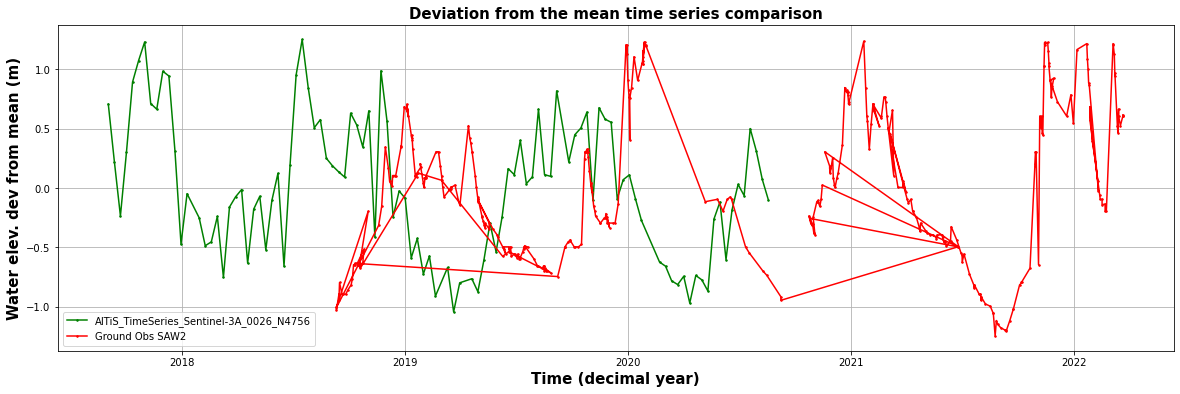

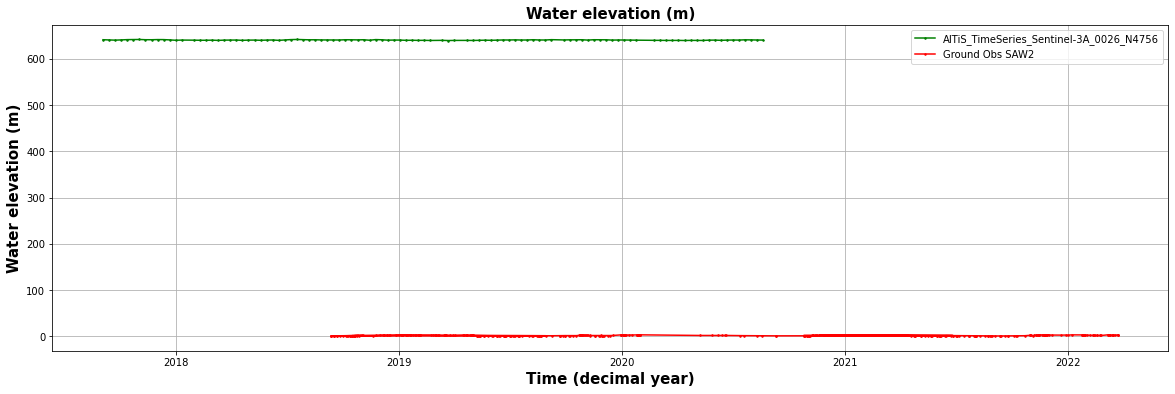

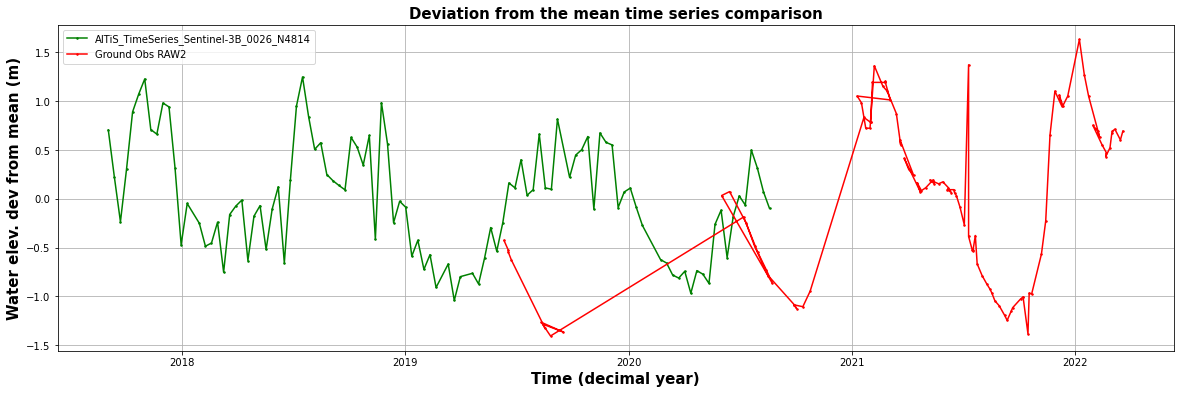

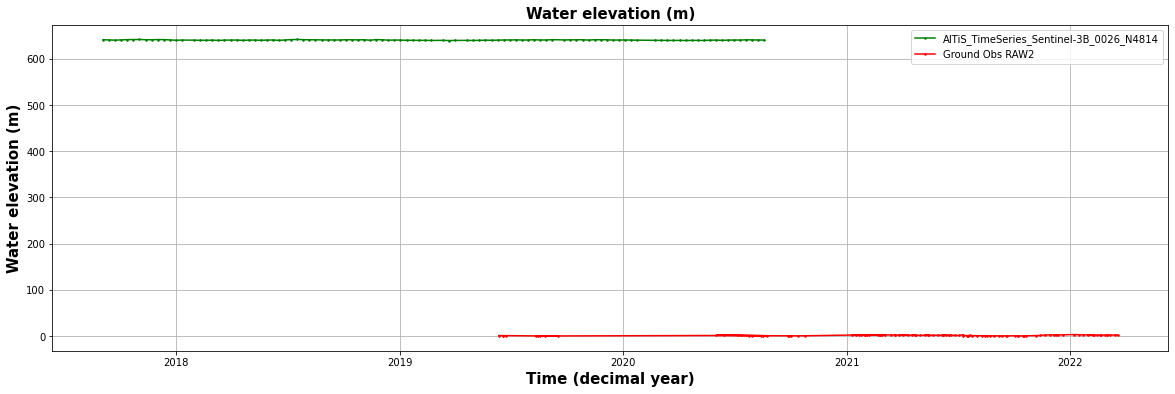

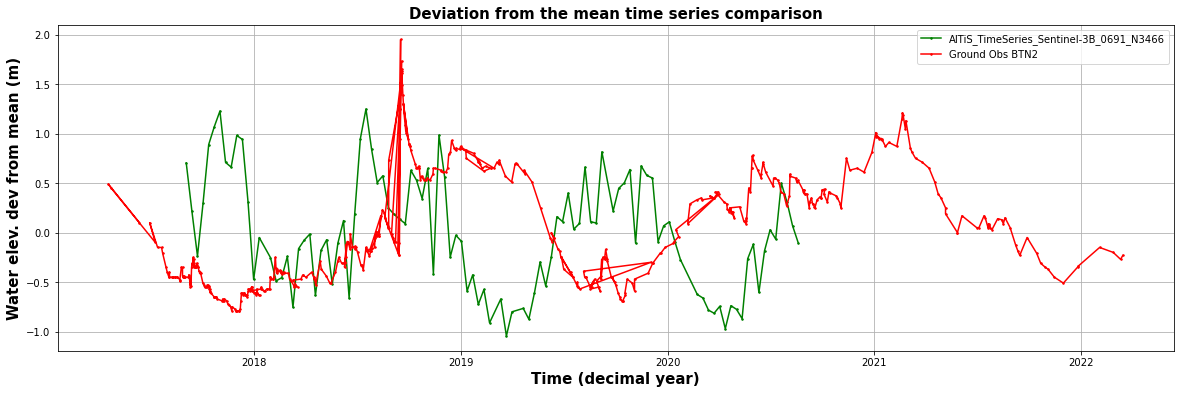

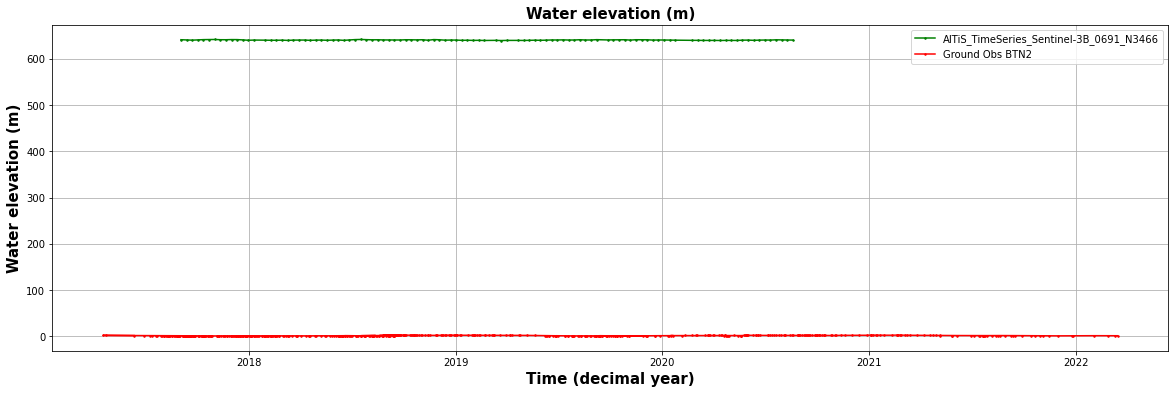

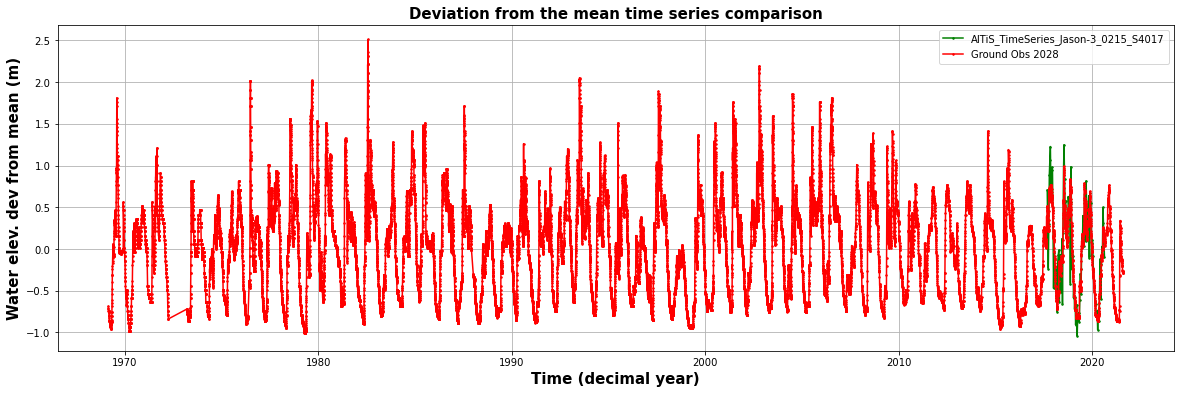

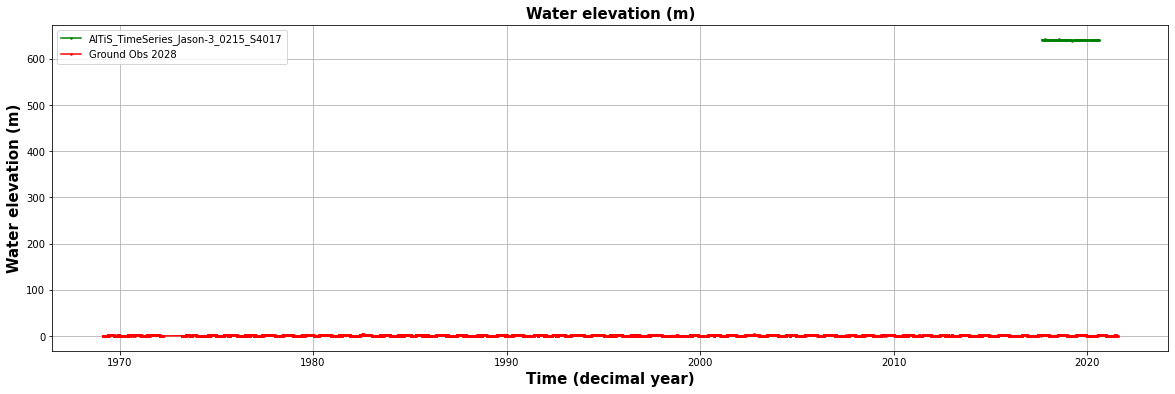

In [14]:
# #read all altiss 
import geopandas as gpd
from timezonefinder import TimezoneFinder

# import geoplot as gplt
# #WRITE AS FUNCTIONS TO MOVE LATER
# #Read shapefile with all the coordinates and the id of the files
path= '/home/angelica/Dropbox/Research/LOCSS/Denis_Sylvain/15_L_Altis_20220318/lonlat_vs_altis_ed.shp'
lon_fd='lon'
lat_fd='lat'
# altis_shp
altis_shp=gpd.read_file(path)
#Add the time_zone to each coordinate 
tf=TimezoneFinder()
# altis_shp['tz']=[tf.timezone_at(lng=row[0], lat=row[1]) for row in altis_shp[[lon_fd, lat_fd]]]

altis_shp['tz']=altis_shp.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)

#filter only altis time series with ground observations
altis_w_gts_shp=altis_shp.loc[altis_shp['station_id'].notna()]
print(altis_shp.shape)
print(altis_w_gts_shp.shape)
print(altis_w_gts_shp.columns)
#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'
df_gts=df_ground_ts

st_fd='gauge_id'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999
i=1
for index,row in altis_w_gts_shp.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
    # Plot time series deviation from mean
    plt.figure(i, figsize=(20, 6))
    # jplot=plt.plot(altidy, altiwelev-np.nanmean(altiwelev), '-bo', markersize=2.5, label='Jason-3_011_S2599')
    splot=plt.plot(altis_df['decimal_y'], 
                   altis_df['height']-np.nanmean(altis_df['height']), '-go', markersize=1.5, label=altis_name)
    gplot=plt.plot(df_ground_st['decimal_y'], 
                   df_ground_st['height']-df_ground_st['height'].mean(), '-ro', markersize=1.5, label='Ground Obs '+st_id)
    #plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.xlabel('Time (decimal year)', size=15, weight='bold')
    plt.ylabel('Water elev. dev from mean (m)', size=15, weight='bold')
    plt.grid('on')
    plt.legend()
    plt.title('Deviation from the mean time series comparison', size=15,
              weight='bold')
    # plt.savefig(os.path.splitext(falti)[0]+'_br_segrado_plot.png',
    #             bbox_inches='tight')

    # Plot time series
    plt.figure(i+1, figsize=(20, 6))
    # jplot=plt.plot(altidy, altiwelev, '-bo', markersize=2.5, label='Jason-3_011_S2599')
    splot=plt.plot(altis_df['decimal_y'], 
                   altis_df['height'], '-go', markersize=1.5, label=altis_name)
    gplot=plt.plot(df_ground_st['decimal_y'], 
                   df_ground_st['height'], '-ro', markersize=1.5, label='Ground Obs '+st_id)
    #plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.xlabel('Time (decimal year)', size=15, weight='bold')
    plt.ylabel('Water elevation (m)', size=15, weight='bold')
    plt.grid('on')
    plt.legend()
    plt.title('Water elevation (m)', size=15,
              weight='bold')
    i=i+2
    
    #['gauge_id','source'
    
# def open_match__plot_station_altis(g_path,altis_name, st_id, df_gts, altis_date_fd, altis_height_fd, nodataalti=-9999):


In [11]:
altis_df

,decimal_y,height,year,month,day,hour
0,2017.671440,641.372944,2017,9,3,1
1,2017.698607,640.890107,2017,9,12,23
2,2017.725772,640.432409,2017,9,22,21
3,2017.752939,640.969803,2017,10,2,19
4,2017.780107,641.558408,2017,10,12,17
...,...,...,...,...,...,...
99,2020.522456,640.603177,2020,7,10,5
100,2020.549547,641.167388,2020,7,20,3
101,2020.576639,640.981758,2020,7,30,1
102,2020.603730,640.740058,2020,8,8,23


In [48]:
df1=go.read_ground_data('LOCSS', station_id=lc_lakes)
# df.shape
# df_locss_filtered=df.loc[df['gauge_id'].isin(lc_lakes)]
# df_locss_filtered.shape
x=df1['gauge_id'].unique()
for a in x:
    print(df1.loc[df1['gauge_id']==a].shape)

(536, 24)
(53, 24)
(170, 24)
(256, 24)
(109, 24)
(393, 24)


In [13]:
df_arhn.head(3)

,date,height,source,gauge_id,year,month,day,hour,decimal_y
0,2010-03-01 12:00:00,2.30,ARHN,2830,2010,3,1,12,2010.163014
1,2010-03-02 12:00:00,2.30,ARHN,2830,2010,3,2,12,2010.165753
2,2010-03-03 13:00:00,2.31,ARHN,2830,2010,3,3,12,2010.168493


In [14]:
df_usgs.head(3)

,Unnamed: 0,agency_cd,gauge_id,date,height,X_00065_00003_cd,source,year,month,day,hour,decimal_y
0,1,USGS,2464800,2002-07-04,223.73,A,USGS,2002,7,4,12,2002.505479
1,2,USGS,2464800,2002-07-05,223.66,A,USGS,2002,7,5,12,2002.508219
2,3,USGS,2464800,2002-07-06,223.61,A,USGS,2002,7,6,12,2002.510959
